# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

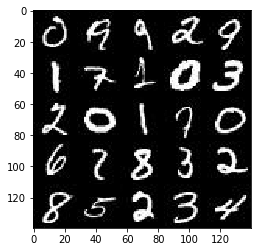

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

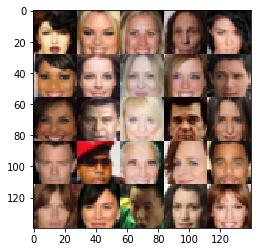

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32,(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real,  input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # TODO: Implement Function
        l1 = tf.layers.conv2d(images,32,5,strides=2,padding='same')
        l1 = tf.layers.batch_normalization(l1, training=True)
        relu1 = leaky_relu(l1)
        relu1 = tf.nn.dropout(relu1, 0.5)
        #14 *14 *64
    
        l2 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(l2, training=True)
        relu2 = leaky_relu(l2)
        relu2 = tf.nn.dropout(relu2, 0.5)
        # 7 * 7 *128
    
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*64))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim,is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
   
    # TODO: Implement Function
    with tf.variable_scope("generator",reuse = not is_train):
        l1 = tf.layers.dense(z, 7*7*64)
        # Reshape it to start the convolutional stack
        l1 = tf.reshape(l1, (-1, 7, 7, 64))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(0.2 * l1, l1)
        # 7x7x128 now
        l2 = tf.layers.conv2d_transpose(l1, 32, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(0.2 * l2, l2)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(l2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_real,d_logits_real = discriminator(input_real)
    d_fake,d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

     # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return  d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _  = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
               
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.4195... Generator Loss: 0.1235
Epoch 1/2... Discriminator Loss: 1.8908... Generator Loss: 0.5698
Epoch 1/2... Discriminator Loss: 2.4648... Generator Loss: 1.9125
Epoch 1/2... Discriminator Loss: 1.7586... Generator Loss: 1.6236
Epoch 1/2... Discriminator Loss: 1.4344... Generator Loss: 0.6910
Epoch 1/2... Discriminator Loss: 1.4993... Generator Loss: 0.4427
Epoch 1/2... Discriminator Loss: 1.5769... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 1.5127... Generator Loss: 1.1102
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.6952
Epoch 1/2... Discriminator Loss: 1.6797... Generator Loss: 1.4991


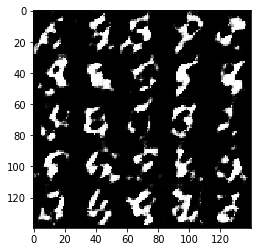

Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 1.1007
Epoch 1/2... Discriminator Loss: 1.3715... Generator Loss: 0.5961
Epoch 1/2... Discriminator Loss: 1.5226... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.6078... Generator Loss: 0.3888
Epoch 1/2... Discriminator Loss: 1.4263... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.7453
Epoch 1/2... Discriminator Loss: 1.4224... Generator Loss: 0.4590
Epoch 1/2... Discriminator Loss: 1.4785... Generator Loss: 0.9736
Epoch 1/2... Discriminator Loss: 1.3472... Generator Loss: 0.8842


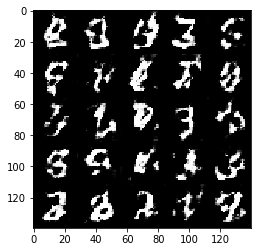

Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 1.0604
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.7101
Epoch 1/2... Discriminator Loss: 1.5179... Generator Loss: 0.4045
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.5031
Epoch 1/2... Discriminator Loss: 1.4866... Generator Loss: 0.5477
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.5474
Epoch 1/2... Discriminator Loss: 1.5612... Generator Loss: 0.4132
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 0.6908
Epoch 1/2... Discriminator Loss: 1.4860... Generator Loss: 0.4181
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.6626


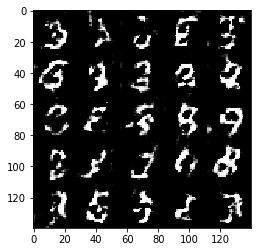

Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.5774
Epoch 1/2... Discriminator Loss: 1.4618... Generator Loss: 0.4420
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.5660
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.5705
Epoch 1/2... Discriminator Loss: 1.4542... Generator Loss: 0.5151
Epoch 1/2... Discriminator Loss: 1.4319... Generator Loss: 0.4477
Epoch 1/2... Discriminator Loss: 1.4153... Generator Loss: 0.6020
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.7335
Epoch 1/2... Discriminator Loss: 1.3175... Generator Loss: 0.7614
Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 0.6039


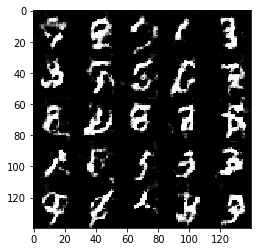

Epoch 1/2... Discriminator Loss: 1.4305... Generator Loss: 0.6775
Epoch 1/2... Discriminator Loss: 1.4263... Generator Loss: 0.4821
Epoch 1/2... Discriminator Loss: 1.4200... Generator Loss: 1.0723
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.7672
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 1.6546... Generator Loss: 0.2932
Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.7234
Epoch 2/2... Discriminator Loss: 1.3640... Generator Loss: 0.8196
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 0.7366
Epoch 2/2... Discriminator Loss: 1.4063... Generator Loss: 0.9055


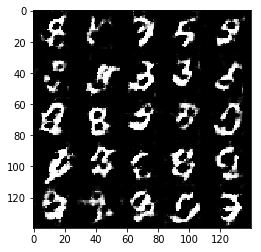

Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.8695
Epoch 2/2... Discriminator Loss: 1.4001... Generator Loss: 0.9786
Epoch 2/2... Discriminator Loss: 1.3450... Generator Loss: 0.6762
Epoch 2/2... Discriminator Loss: 1.5286... Generator Loss: 0.4989
Epoch 2/2... Discriminator Loss: 1.3665... Generator Loss: 0.6062
Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 0.9269
Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.9149
Epoch 2/2... Discriminator Loss: 1.3573... Generator Loss: 0.6698
Epoch 2/2... Discriminator Loss: 1.3905... Generator Loss: 0.8111


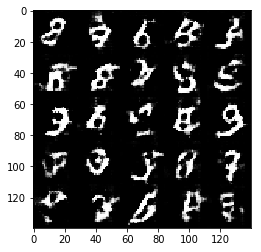

Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 1.4198... Generator Loss: 0.5264
Epoch 2/2... Discriminator Loss: 1.3778... Generator Loss: 0.7462
Epoch 2/2... Discriminator Loss: 1.3679... Generator Loss: 0.6787
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.5992
Epoch 2/2... Discriminator Loss: 1.4405... Generator Loss: 0.9207
Epoch 2/2... Discriminator Loss: 1.3630... Generator Loss: 0.8244
Epoch 2/2... Discriminator Loss: 1.4160... Generator Loss: 0.8750
Epoch 2/2... Discriminator Loss: 1.3464... Generator Loss: 0.7017
Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.7063


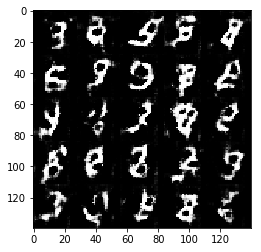

Epoch 2/2... Discriminator Loss: 1.3745... Generator Loss: 0.7637
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.7872
Epoch 2/2... Discriminator Loss: 1.3684... Generator Loss: 0.6866
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 1.3722... Generator Loss: 0.8056
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.6854
Epoch 2/2... Discriminator Loss: 1.4640... Generator Loss: 0.4593
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.7769
Epoch 2/2... Discriminator Loss: 1.4067... Generator Loss: 0.8749
Epoch 2/2... Discriminator Loss: 1.3778... Generator Loss: 0.7422


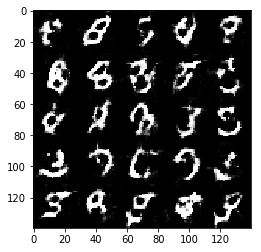

Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 1.0795
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.6903
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.8474
Epoch 2/2... Discriminator Loss: 1.3814... Generator Loss: 0.6578
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 0.9651
Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.6168
Epoch 2/2... Discriminator Loss: 1.3529... Generator Loss: 0.6795
Epoch 2/2... Discriminator Loss: 1.3665... Generator Loss: 0.6035
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.6289


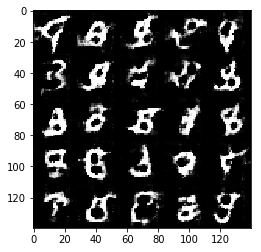

Epoch 2/2... Discriminator Loss: 1.3518... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 1.3711... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 0.7871


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.02
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6907... Generator Loss: 0.4800
Epoch 1/1... Discriminator Loss: 1.7554... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.6983... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.2788
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 2.4462
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8881


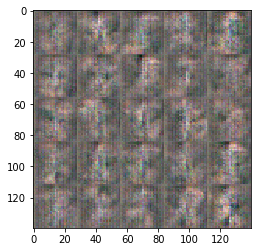

Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 2.5375
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 1.4615
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 1.2902
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.6417


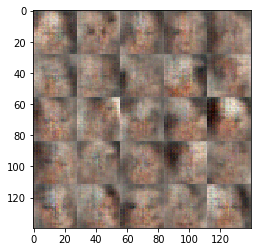

Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.5103
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.6250


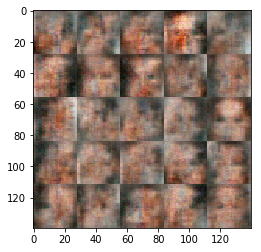

Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7568


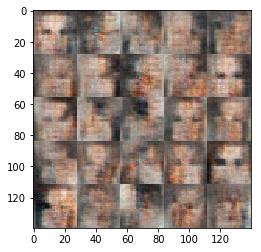

Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6623


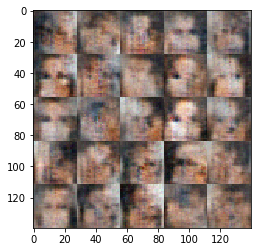

Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6668


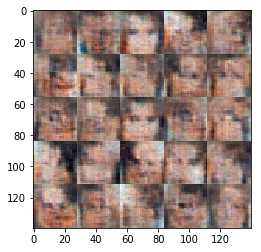

Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7674


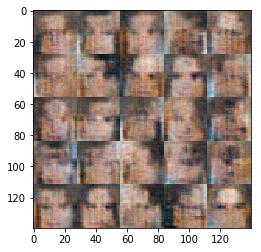

Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7030


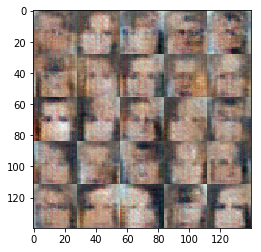

Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6322


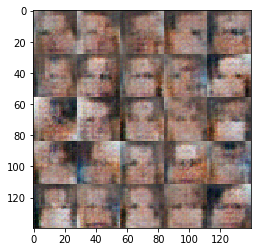

Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6851


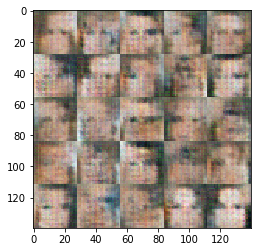

Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.6663


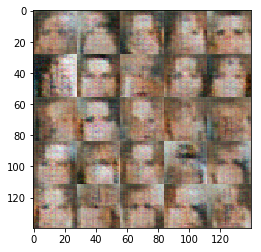

Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.7581


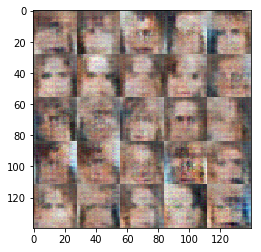

Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7056


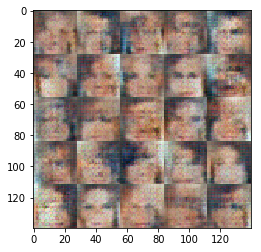

Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6604


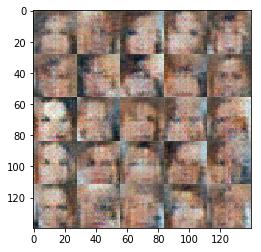

Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.6673


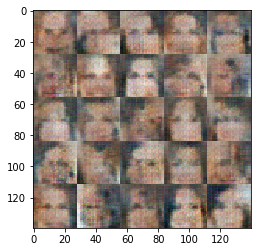

Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6977


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.